<a href="https://colab.research.google.com/github/shagunshukla09/medical-image-segmentation/blob/main/Copy_of_Copy_of_Equalization_Final_Lung_Cancer_ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
    )

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Dataset/train',
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Dataset/test',
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/ColabNotebooks/Dataset/test',
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Found 4181 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Histogram Equalization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

figsize = (8, 8)

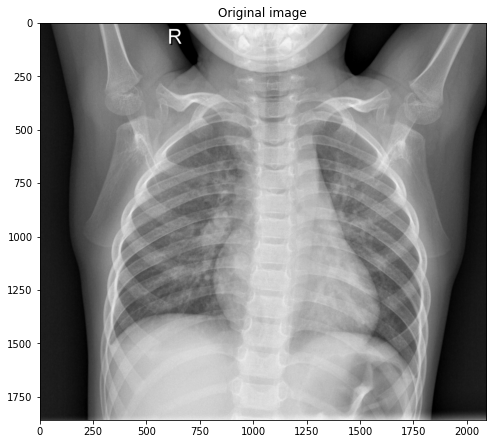

In [ ]:
I = cv2.imread("/content/drive/MyDrive/ColabNotebooks/Dataset/train/NORMAL/IM-0115-0001.jpeg", 0)
plt.figure(figsize=figsize)
plt.imshow(I, cmap="gray", vmin=0, vmax=255)
plt.title("Original image")
plt.show()

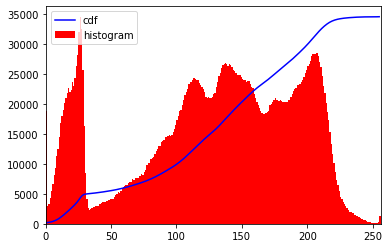

In [ ]:
#Original Image Histogram
hist,bins = np.histogram(I.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(I.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [ ]:
img_eq = cv2.equalizeHist(I)

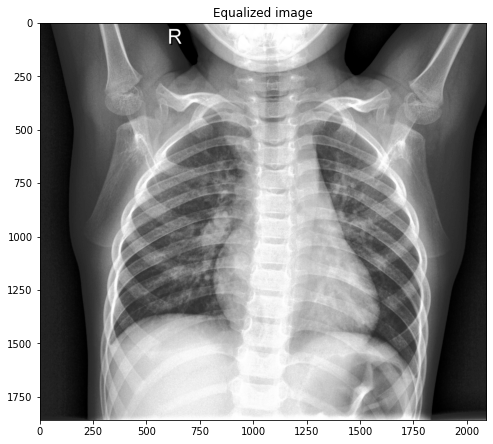

In [ ]:
plt.figure(figsize=figsize)
plt.imshow(img_eq, cmap="gray", vmin=0, vmax=255)
plt.title("Equalized image")
plt.show()

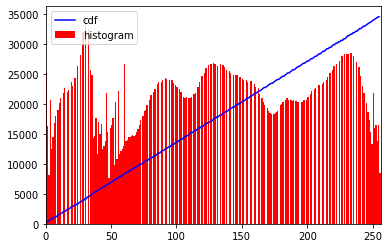

In [ ]:
hist,bins = np.histogram(img_eq.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_eq.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

#Model Generation

In [ ]:
base_model = tf.keras.applications.ResNet152(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_model.layers:
    layer.trainable=True
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))
model.summary()

234698864/234698864 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 2048)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                         

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','AUC','Precision','Recall'])

#Model Running

In [ ]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch= 75
    )

Epoch 1/10
28/75 [==========>...................] - ETA: 2:45 - loss: 1.1170 - accuracy: 0.5089 - auc: 0.4959 - precision: 0.5072 - recall: 0.4732

In [ ]:
model.evaluate(train_generator)

77/77 [==============================] - 11s 146ms/step - loss: 0.1844 - accuracy: 0.9478 - auc: 0.9862 - precision: 0.6707 - recall: 0.9869


[0.18438692390918732,
 0.9477977156639099,
 0.9861701726913452,
 0.6707317233085632,
 0.9869494438171387]

In [ ]:
model.evaluate(test_generator)

40/40 [==============================] - 79s 2s/step - loss: 1.2750 - accuracy: 0.7714 - auc: 0.8835 - precision: 0.5560 - recall: 0.8667


[1.274994134902954,
 0.7714285850524902,
 0.883539080619812,
 0.5560081601142883,
 0.8666666746139526]

In [ ]:
model.evaluate(validation_generator)

12/12 [==============================] - 2s 134ms/step - loss: 1.3263 - accuracy: 0.6923 - auc: 0.8896 - precision: 0.5203 - recall: 0.8462


[1.32632577419281,
 0.692307710647583,
 0.8895866274833679,
 0.5202702879905701,
 0.8461538553237915]

1/1 [==============================] - 3s 3s/step
[[0.39800122 0.01143896 0.13891414 0.9963224 ]]
THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma


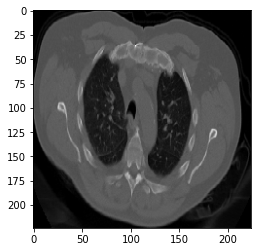

In [ ]:
from keras.preprocessing import image
img = tf.keras.utils.load_img('/content/drive/MyDrive/Colab Notebooks/Final Year Project/Dataset_1/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png',target_size=(224,224))
imag = tf.keras.utils.img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
  op="Adenocarcinoma"
elif a==1:
  op="large cell carcinoma"
elif a==2:
  op="normal (void of cancer)"
else:
  op="squamous cell carcinoma"
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))


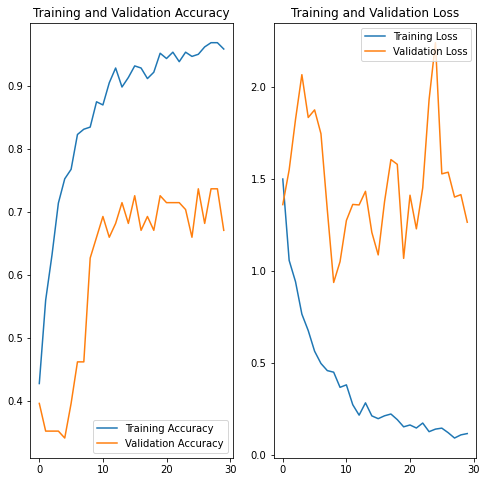

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()